# Compare clustering using finite mixture vs DP mixture of Gaussians

In [24]:
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils.dp_mixgauss_utils import NormalInverseWishart, gmm_gibbs, dp_mixgauss_gibbs

import jax.numpy as jnp
from jax import random, vmap
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib.patches import Ellipse, transforms

In [13]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [14]:
dim = 2
concentration = 1.0
n_data = 300
n_gibbs_samples = 1000
burn_in = 200
mean_precisions = [0.01, 0.5]
n_clusters_true = 4
n_clusters_input = [2, 4, 6]

In [18]:
def _replace_period(m): 
    # replace '.' with 'p' in a string of numeric value 
    return 'p'.join(str(m).split('.'))

In [19]:
# Generate data and cluster it via gmm and dp_mixgauss

data_set = {}
samples_set = {}

for m_precision in mean_precisions:
    print(f"Example with the precision parameter of the NIW prior being {m_precision}.")
    print("Generating data ...")
    
    # Generating the true data from a finite mixture model
    key = random.PRNGKey(0)
    key, *subkeys = random.split(key, 4)
    niw_params = dict(loc=jnp.zeros(dim), mean_precision=m_precision, df=dim + 5, scale=jnp.eye(dim))
    niw = NormalInverseWishart(**niw_params)
    cluster_weights = random.dirichlet(subkeys[0], 5.0 * jnp.ones(n_clusters_true))
    
    # cluster assignment of each datum
    cluster_indices = random.categorical(subkeys[1], jnp.log(cluster_weights), shape=(n_data,))
    cluster_params = niw.sample(seed=subkeys[2], sample_shape=(n_clusters_true,))
    cluster_covs = cluster_params["Sigma"]
    cluster_means = cluster_params["mu"]
    
    # data
    mean_per_datum = cluster_means[cluster_indices]
    cov_per_datum = cluster_covs[cluster_indices]
    key, *subkeys = random.split(key, n_data + 1)
    data = vmap(random.multivariate_normal, in_axes=(0, 0, 0))(jnp.array(subkeys), mean_per_datum, cov_per_datum)
    dname = f"data_{_replace_period(m_precision)}"
    data_set[dname] = data

    print("Begin clustering via...")
    # Clustering via finite mixture model
    for n_clusters in n_clusters_input:
        print(f"finite mixture model with K = {n_clusters};")
        gmm_samples = gmm_gibbs(key, burn_in + n_gibbs_samples, data, concentration, n_clusters, niw_params)
        gmm_samples = gmm_samples[burn_in:]
        fname = f"gmm_{n_clusters}_data_{_replace_period(m_precision)}"
        samples_set[fname] = gmm_samples

    # Clustering via DP mixture model
    print(f"DP mixture model.")
    dp_samples = dp_mixgauss_gibbs(key, burn_in + n_gibbs_samples, data, concentration, niw_params)
    dp_samples = dp_samples[burn_in:]
    fname = f"dp_data_{_replace_period(m_precision)}"
    samples_set[fname] = dp_samples
    print("Finish clustering.")

Example with the precision parameter of the NIW prior being 0.01.
Generating data ...
Begin clustering via...
finite mixture model with K = 2;
finite mixture model with K = 4;
finite mixture model with K = 6;
DP mixture model.
Finish clustering.
Example with the precision parameter of the NIW prior being 0.5.
Generating data ...
Begin clustering via...
finite mixture model with K = 2;
finite mixture model with K = 4;
finite mixture model with K = 6;
DP mixture model.
Finish clustering.


In [36]:
def plot_ellipse(Sigma, mu, ax, n_std=2.0, facecolor="none", edgecolor="k", **kwargs):
    """Plot an ellipse to with centre `mu` and axes defined by `Sigma`.
    This function is copied directly from 
    https://github.com/probml/ssm-jax/blob/main/ssm_jax/plotting.py#L72 
    """
    cov = Sigma
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    ellipse = Ellipse(
        (0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, edgecolor=edgecolor, **kwargs
    )

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)

    return ax.add_patch(ellipse)

(DeviceArray([0, 1], dtype=int32), DeviceArray([203,  97], dtype=int32))
(DeviceArray([0, 1, 2], dtype=int32), DeviceArray([ 23,  72, 205], dtype=int32))
(DeviceArray([1, 2, 4, 5], dtype=int32), DeviceArray([ 21,  36, 171,  72], dtype=int32))
(DeviceArray([0, 3, 4, 5], dtype=int32), DeviceArray([ 22,  72,  29, 177], dtype=int32))
(DeviceArray([0, 1], dtype=int32), DeviceArray([  8, 292], dtype=int32))
(DeviceArray([0, 2, 3], dtype=int32), DeviceArray([  1, 237,  62], dtype=int32))
(DeviceArray([1, 2, 3, 4, 5], dtype=int32), DeviceArray([250,  31,   3,  12,   4], dtype=int32))
(DeviceArray([0, 4, 5], dtype=int32), DeviceArray([  1,  11, 288], dtype=int32))


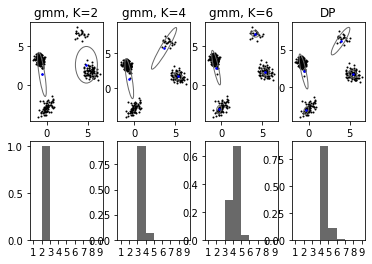

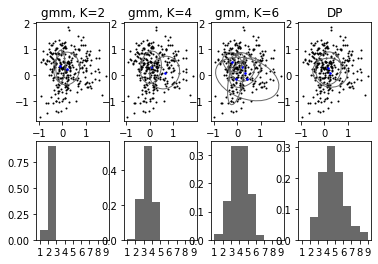

In [44]:
# Plot the clustering result of gmm and dp_mixgauss in one figure

for data_key in data_set.keys():
    data = data_set[data_key]
    fig_col = 4
    fig_row = 2
    fig, axes = plt.subplots(fig_row, fig_col)
    
    i = 0
    for sample_key in samples_set.keys():
        if sample_key.split('_')[-1] != data_key.split('_')[-1]:
            continue
        samples = samples_set[sample_key]
        final = samples[-1]
        print(jnp.unique(final, return_counts=True))
        
        # Plot the final cluster
        ax = axes[0, i]
        title = 'DP' if sample_key.split('_')[0] == 'dp' else "gmm, K="+sample_key.split('_')[1]
        ax.set_title(title)
        ax.scatter(data[:, 0], data[:, 1], s=2, c='k')
        final_clusters = samples[-1, :]
        for cluster_index in jnp.unique(final_clusters):
            subset = data[final_clusters == cluster_index, :]
            if subset.shape[0] == 1:
                continue
            mu = jnp.mean(subset, axis=0)
            ax.scatter(mu[0], mu[1], s=5, c='r')
            Sigma = np.cov(subset, rowvar=False)
            plot_ellipse(Sigma, mu, ax, n_std=1.0, facecolor="none", edgecolor="dimgrey")

        # Histogram of the frequences of number of clusters
        # returned by the Gibbs sampler
        ax = axes[1, i]
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        n_clusters = jnp.array([len(jnp.unique(s)) for s in samples])
        ax.hist(n_clusters, range = (1, 9), bins=8, density=True, color='dimgrey')
        i += 1

In [33]:
#%env LATEXIFY= 1
%env FIG_DIR=dp-figures

env: FIG_DIR=dp-figures


(DeviceArray([0, 1], dtype=int32), DeviceArray([203,  97], dtype=int32))
saving image to dp-figures/dp_mixgauss_cluster_gmm_2_data_0p01_scatter
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_gmm_2_data_0p01_scatter
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_gmm_2_data_0p01_histogram
Figure size: [6. 4.]
(DeviceArray([0, 1, 2], dtype=int32), DeviceArray([ 23,  72, 205], dtype=int32))
saving image to dp-figures/dp_mixgauss_cluster_gmm_4_data_0p01_scatter
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_gmm_4_data_0p01_scatter
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_gmm_4_data_0p01_scatter
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_gmm_4_data_0p01_histogram
Figure size: [6. 4.]
(DeviceArray([1, 2, 4, 5], dtype=int32), DeviceArray([ 21,  36, 171,  72], dtype=int32))
saving image to dp-figures/dp_mixgauss_cluster_gmm_6_data_0p01_scatter
Figure size: [6. 4.]
saving image to d

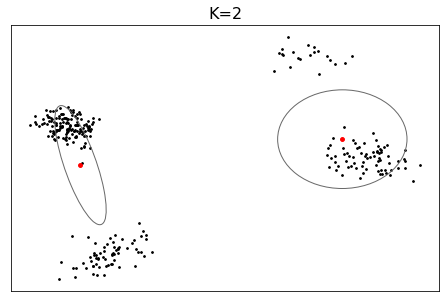

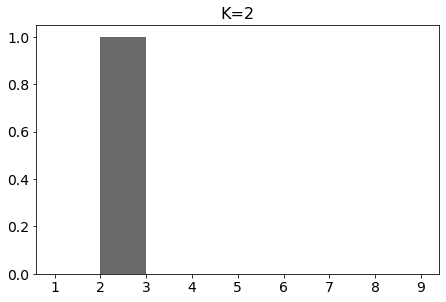

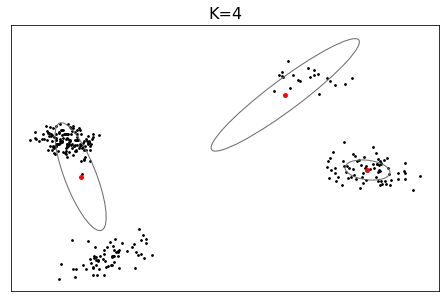

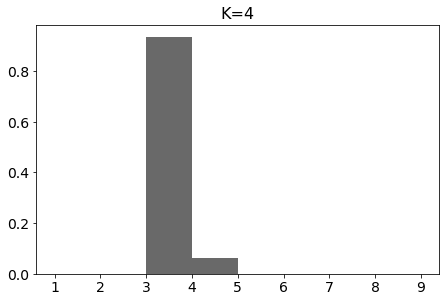

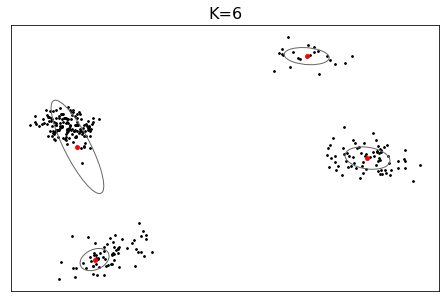

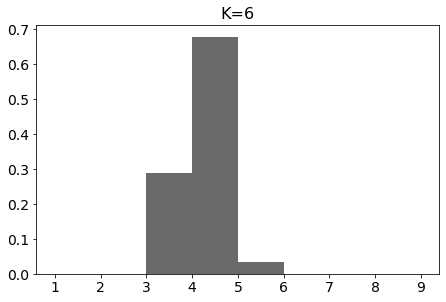

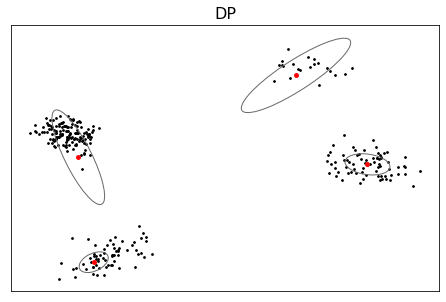

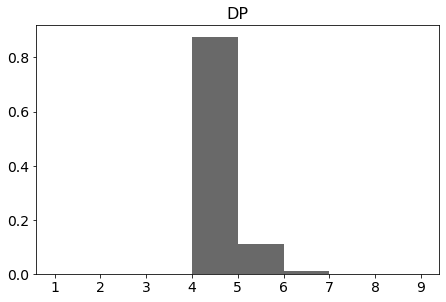

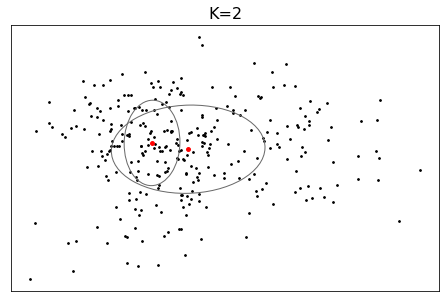

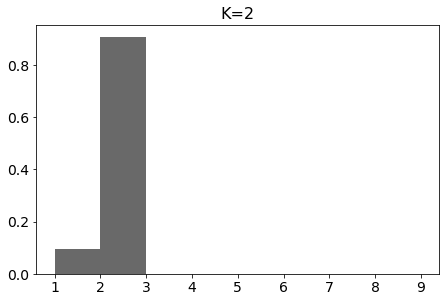

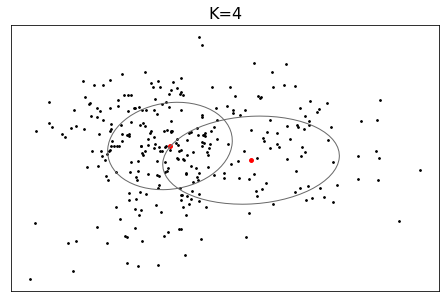

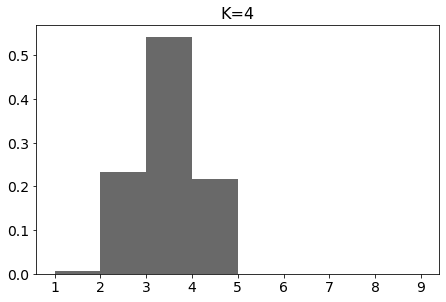

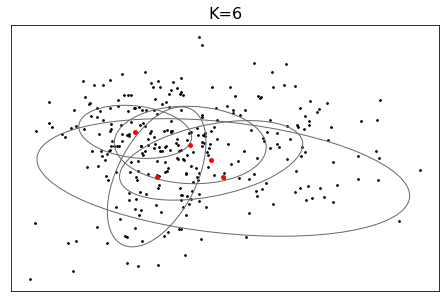

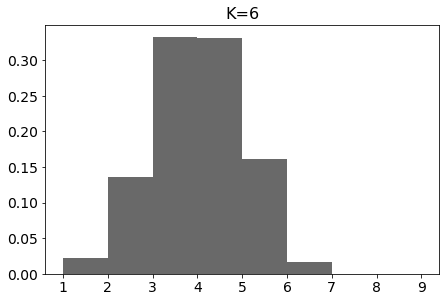

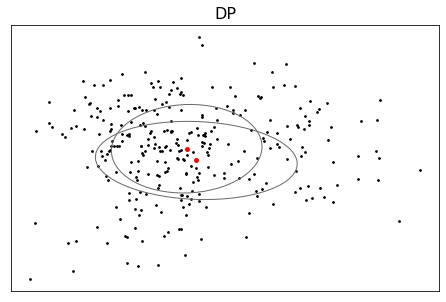

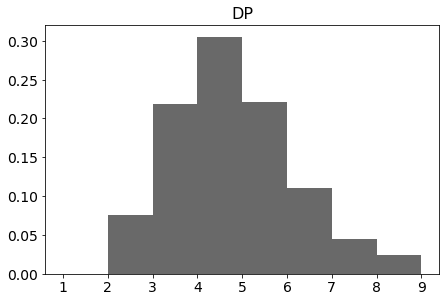

In [50]:
# Display result in separate figures and save

for sample_key in samples_set.keys():
    samples = samples_set[sample_key]
    data = data_set["_".join(sample_key.split("_")[-2:])]
    final = samples[-1]
    print(jnp.unique(final, return_counts=True))
    # Plot the final cluster
    fig, ax = plt.subplots()
    title = "DP" if sample_key.split("_")[0] == "dp" else "K=" + sample_key.split("_")[1]
    ax.set_title(title, fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(data[:, 0], data[:, 1], c='k', s=3)
    final_clusters = samples[-1, :]
    for cluster_index in jnp.unique(final_clusters):
        subset = data[final_clusters == cluster_index, :]
        if subset.shape[0] == 1:
            continue
        mu = jnp.mean(subset, axis=0)
        ax.scatter(mu[0], mu[1], c='r', s=15)
        Sigma = np.cov(subset, rowvar=False)
        plot_ellipse(Sigma, mu, ax, n_std=1.0, facecolor="none", edgecolor="dimgrey")
        fname = "dp_mixgauss_cluster_" + sample_key + "_scatter"
        pml.savefig(fname)

    # Histogram of the frequences of number of clusters
    # returned by the Gibbs sampler
    fig, ax = plt.subplots()
    ax.set_title(title, fontsize=16)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    n_clusters = jnp.array([len(jnp.unique(s)) for s in samples])
    ax.hist(n_clusters, range=(1, 9), bins=8, density=True, color='dimgrey')
    ax.tick_params(axis='x', labelsize= 14)
    ax.tick_params(axis='y', labelsize= 14)
    fname = "dp_mixgauss_cluster_" + sample_key + "_histogram"
    pml.savefig(fname)

(DeviceArray([0, 1, 2, 3, 4, 5], dtype=int32), DeviceArray([  8,  11,   2,  72,  46, 161], dtype=int32))
(DeviceArray([1, 3, 4, 5], dtype=int32), DeviceArray([ 22,  72,  44, 162], dtype=int32))
(DeviceArray([0, 3, 4, 5], dtype=int32), DeviceArray([ 22,  72,  29, 177], dtype=int32))
(DeviceArray([2, 3], dtype=int32), DeviceArray([283,  17], dtype=int32))
(DeviceArray([0, 1, 2, 3], dtype=int32), DeviceArray([  1,   2,  38, 259], dtype=int32))
(DeviceArray([0, 4, 5], dtype=int32), DeviceArray([  1,  11, 288], dtype=int32))


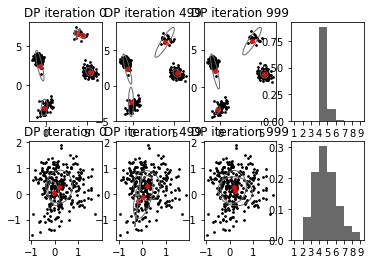

In [54]:
# Plot the clustering result of dp_mixgauss in one figure

timesteps = [0, 499, 999]
fig_col = 4
fig_row = 2
fig, axes = plt.subplots(fig_row, fig_col)
i = 0
for data_key in data_set.keys():
    data = data_set[data_key]
    j = 0
    for t in timesteps:
        sample_key = 'dp_' + data_key
        samples = samples_set[sample_key]
        sample_t = samples[t, :]
        print(jnp.unique(sample_t, return_counts=True))
        # Plot the cluster
        ax = axes[i, j]
        title = f'DP iteration {t+1}'
        ax.set_title(title)
        ax.scatter(data[:, 0], data[:, 1], c='k', s=3)
        for cluster_index in jnp.unique(sample_t):
            subset = data[sample_t == cluster_index, :]
            if subset.shape[0] == 1:
                continue
            mu = jnp.mean(subset, axis=0)
            ax.scatter(mu[0], mu[1], c='r', s=15)
            Sigma = np.cov(subset, rowvar=False)
            plot_ellipse(Sigma, mu, ax, n_std=1.0, facecolor="none", edgecolor="dimgrey")
        
        j += 1

    # Histogram of the frequences of number of clusters
    # returned by the Gibbs sampler
    ax = axes[i, j]
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    n_clusters = jnp.array([len(jnp.unique(s)) for s in samples])
    ax.hist(n_clusters, range = (1, 9), bins=8, density=True, color='dimgrey')

    i += 1

(DeviceArray([0, 1, 2, 3, 4, 5], dtype=int32), DeviceArray([  8,  11,   2,  72,  46, 161], dtype=int32))
saving image to dp-figures/dp_mixgauss_cluster_dp_data_0p01_scatter1
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_dp_data_0p01_scatter1
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_dp_data_0p01_scatter1
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_dp_data_0p01_scatter1
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_dp_data_0p01_scatter1
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_dp_data_0p01_scatter1
Figure size: [6. 4.]
(DeviceArray([1, 3, 4, 5], dtype=int32), DeviceArray([ 22,  72,  44, 162], dtype=int32))
saving image to dp-figures/dp_mixgauss_cluster_dp_data_0p01_scatter500
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_dp_data_0p01_scatter500
Figure size: [6. 4.]
saving image to dp-figures/dp_mixgauss_cluster_dp_data_0p01_scatter500
Figure size

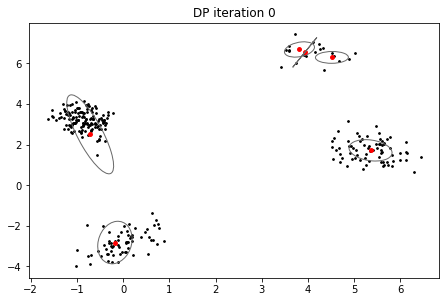

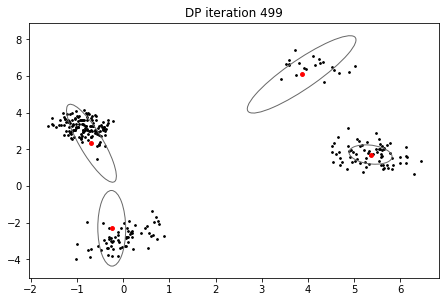

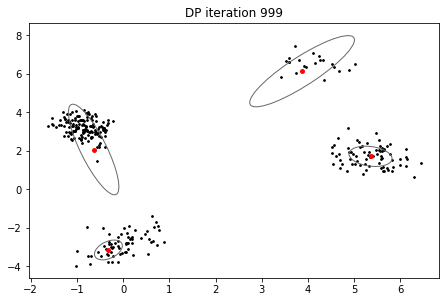

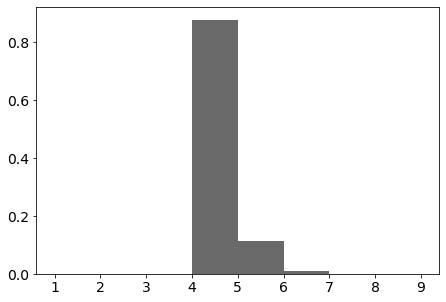

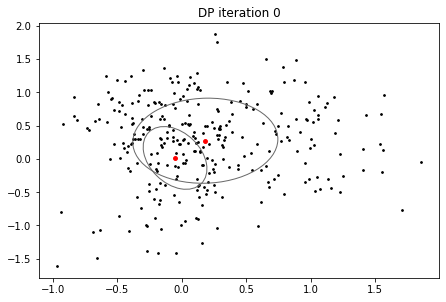

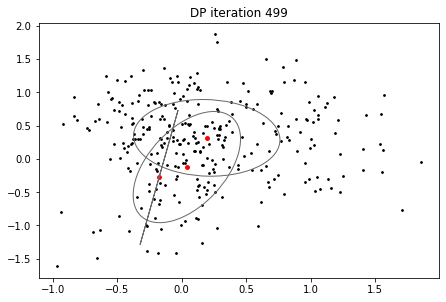

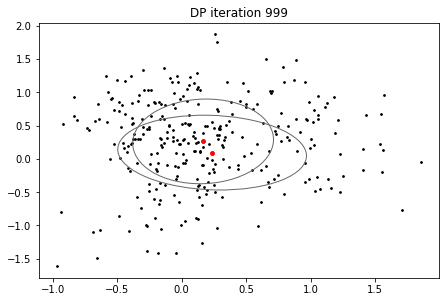

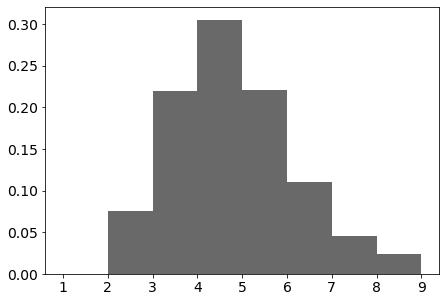

In [56]:
# Display result in separate figures and save

timesteps = [0, 499, 999]

for data_key in data_set.keys():
    data = data_set[data_key]
    j = 0
    for t in timesteps:
        sample_key = 'dp_' + data_key
        samples = samples_set[sample_key]
        sample_t = samples[t, :]
        print(jnp.unique(sample_t, return_counts=True))
        # Plot the cluster
        fig, ax = plt.subplots()
        title = f'DP iteration {t}'
        ax.set_title(title)
        ax.scatter(data[:, 0], data[:, 1], c='k', s=3)
        for cluster_index in jnp.unique(sample_t):
            subset = data[sample_t == cluster_index, :]
            if subset.shape[0] == 1:
                continue
            mu = jnp.mean(subset, axis=0)
            ax.scatter(mu[0], mu[1], c='r', s=15)
            Sigma = np.cov(subset, rowvar=False)
            plot_ellipse(Sigma, mu, ax, n_std=1.0, facecolor="none", edgecolor="dimgrey")
            fname = "dp_mixgauss_cluster_" + sample_key + "_scatter" + str(t+1)
            pml.savefig(fname)

    # Histogram of the frequences of number of clusters
    # returned by the Gibbs sampler
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    n_clusters = jnp.array([len(jnp.unique(s)) for s in samples])
    ax.hist(n_clusters, range = (1, 9), bins=8, density=True, color='dimgrey')
    ax.tick_params(axis='x', labelsize= 14)
    ax.tick_params(axis='y', labelsize= 14)
    fname = "dp_mixgauss_cluster_" + sample_key + "_histogram"
    pml.savefig(fname)